# Introduction and data loading

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
Layoffs = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/W_layoffs.csv")
Layoffs.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised_millions
0,Atlassian,Sydney,Other,500.0,0.05,3/6/2023,Post-IPO,Australia,210.0
1,SiriusXM,New York City,Media,475.0,0.08,3/6/2023,Post-IPO,United States,525.0
2,Alerzo,Ibadan,Retail,400.0,NaN,3/6/2023,Series B,Nigeria,16.0
3,UpGrad,Mumbai,Education,120.0,NaN,3/6/2023,Unknown,India,631.0
4,Loft,Sao Paulo,Real Estate,340.0,0.15,3/3/2023,Unknown,Brazil,788.0


# EDA For Layoffs World wide

## Data Cleaning and Preparing

In [96]:
# Checked for missing values
print("Missing values:", Layoffs.isnull().sum())

Missing values: company                    0
location                   0
industry                   4
total_laid_off           740
percentage_laid_off      785
date                       1
stage                      6
country                    0
funds_raised_millions    209
dtype: int64


In [97]:
# Filled missing values in numerical columns with the mean
numerical_columns = Layoffs.select_dtypes(include=np.number).columns
for col in numerical_columns:
    if Layoffs[col].isnull().any():
        Layoffs[col].fillna(Layoffs[col].mean(), inplace=True)

# Filled missing values in categorical columns with the most frequent value
categorical_columns = Layoffs.select_dtypes(exclude=np.number).columns
for col in categorical_columns:
    if Layoffs[col].isnull().any():
        Layoffs[col].fillna(Layoffs[col].mode()[0], inplace=True)

# Verify if there are any more missing values
print("Missing values after imputation:", Layoffs.isnull().sum())

Missing values after imputation: company                  0
location                 0
industry                 0
total_laid_off           0
percentage_laid_off      0
date                     0
stage                    0
country                  0
funds_raised_millions    0
dtype: int64


<ipython-input-97-501f6fb63bd0>:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-97-501f6fb63bd0>:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df

In [98]:
# Saved the cleaned data to a new file
Layoffs.to_csv('cleaned_data.csv', index=False)

In [99]:
# Strip any leading/trailing spaces in column names
Layoffs.columns = Layoffs.columns.str.strip()

# Check if the column names are correct
print(Layoffs.columns)

Index(['company', 'location', 'industry', 'total_laid_off',
       'percentage_laid_off', 'date', 'stage', 'country',
       'funds_raised_millions'],
      dtype='object')


In [100]:
# Checked for rows and columns in data
num_rows, num_columns = Layoffs.shape
print('No.of Rows:', num_rows)
print('No.of Columns:', num_columns)

No.of Rows: 2361
No.of Columns: 9


In [101]:
# Display data types of each column
Layoffs.dtypes

,0
company,object
location,object
industry,object
total_laid_off,float64
percentage_laid_off,float64
date,object
stage,object
country,object
funds_raised_millions,float64


In [102]:
# Summary statistics
Layoffs.describe()

,total_laid_off,percentage_laid_off,funds_raised_millions
count,2361.000000,2361.000000,2361.000000
mean,238.358421,0.257917,822.454134
std,637.725232,0.208786,5340.521730
min,3.000000,0.000000,0.000000
25%,50.000000,0.130000,58.000000
50%,154.000000,0.257917,189.000000
75%,238.358421,0.257917,613.000000
max,12000.000000,1.000000,121900.000000


In [103]:
#checking the format of the date from dataset
Layoffs['date'] = pd.to_datetime(Layoffs['date'])
Layoffs.date.min(), Layoffs.date.max()

(Timestamp('2020-03-11 00:00:00'), Timestamp('2023-03-06 00:00:00'))

In [104]:
# Convert 'date' to datetime format
Layoffs['formatted_date'] = pd.to_datetime(Layoffs['date'], format='%d%m%Y', errors='coerce')
# Extract Year, Month, and Day
Layoffs['year'] = Layoffs['formatted_date'].dt.year
Layoffs['month'] = Layoffs['formatted_date'].dt.month
Layoffs['day'] = Layoffs['formatted_date'].dt.day
# Drop rows with NaT if necessary
Layoffs = Layoffs.dropna(subset=['formatted_date'])


In [105]:
Layoffs.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised_millions,formatted_date,year,month,day
0,Atlassian,Sydney,Other,500.0,0.050000,2023-03-06,Post-IPO,Australia,210.0,2023-03-06,2023,3,6
1,SiriusXM,New York City,Media,475.0,0.080000,2023-03-06,Post-IPO,United States,525.0,2023-03-06,2023,3,6
2,Alerzo,Ibadan,Retail,400.0,0.257917,2023-03-06,Series B,Nigeria,16.0,2023-03-06,2023,3,6
3,UpGrad,Mumbai,Education,120.0,0.257917,2023-03-06,Unknown,India,631.0,2023-03-06,2023,3,6
4,Loft,Sao Paulo,Real Estate,340.0,0.150000,2023-03-03,Unknown,Brazil,788.0,2023-03-03,2023,3,3


In [106]:
# Distribution of categorical variables
categorical_columns = Layoffs.select_dtypes(include=['object']).columns
categorical_columns.value_counts()

,count
company,1
location,1
industry,1
stage,1
country,1


## Data Visualization by laid off column

          country  total_laid_off
0   United States   379466.945096
1           India    41236.885256
2     Netherlands    18173.433683
3  United Kingdom    13583.677360
4          Brazil    13074.584207


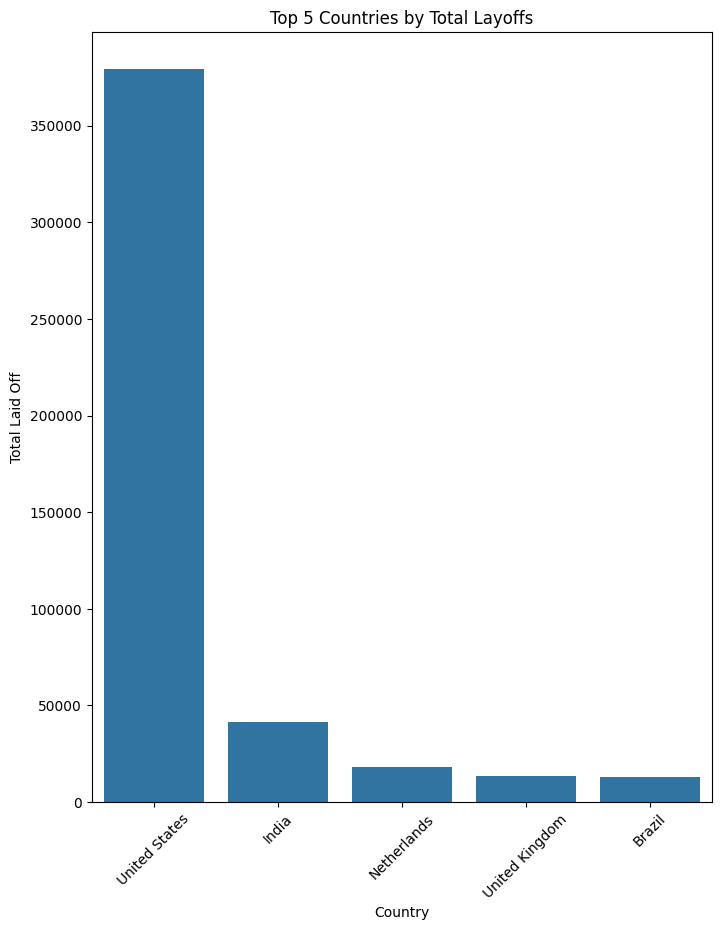

In [107]:
top_5_countries = Layoffs.groupby('country')['total_laid_off'].sum().nlargest(5).reset_index()

print(top_5_countries.head())

#Visualizing
plt.figure(figsize=(8, 10))
sns.barplot(data=top_5_countries, x='country', y='total_laid_off')
plt.title('Top 5 Countries by Total Layoffs')
plt.xlabel('Country')
plt.ylabel('Total Laid Off')
plt.xticks(rotation=45)
plt.show()

     country  total_laid_off
0     Poland            25.0
1   Thailand            55.0
2  Lithuania            60.0
3    Romania            80.0
4      Japan            85.0


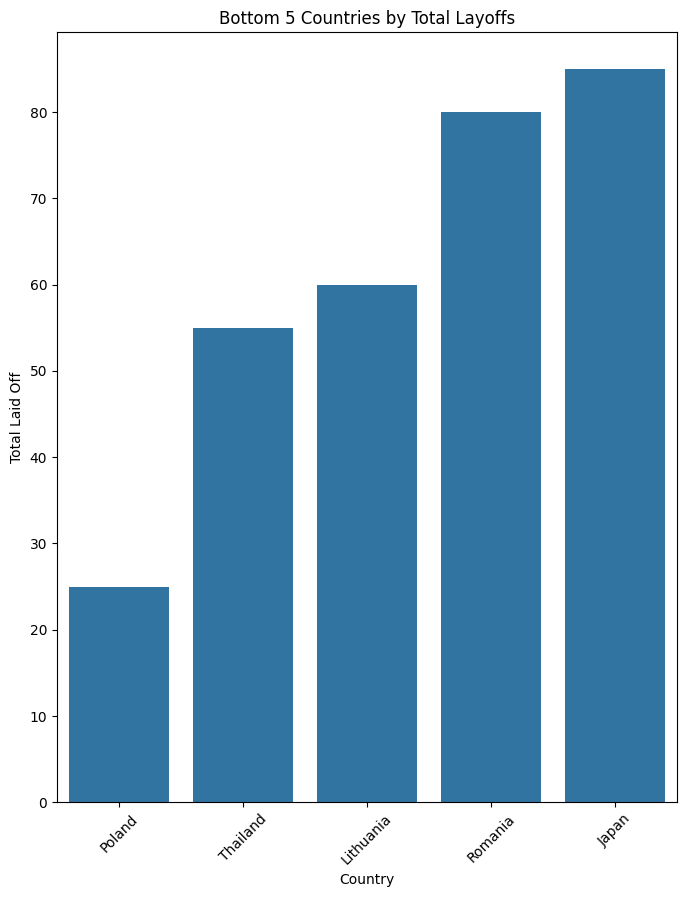

In [108]:
#last 5 counties in layoffs
last_5_countries = Layoffs.groupby('country')['total_laid_off'].sum().nsmallest(5).reset_index()
print(last_5_countries)
#Visualizing
plt.figure(figsize=(8, 10))
sns.barplot(data=last_5_countries, x='country', y='total_laid_off')
plt.title('Bottom 5 Countries by Total Layoffs')
plt.xlabel('Country')
plt.ylabel('Total Laid Off')
plt.xticks(rotation=45)
plt.show()

                       total_laid_off  percentage_laid_off  \
total_laid_off               1.000000            -0.045335   
percentage_laid_off         -0.045335             1.000000   
funds_raised_millions        0.070324            -0.044500   
year                         0.068689            -0.123098   
month                       -0.041582             0.012726   
day                         -0.000947             0.032126   

                       funds_raised_millions      year     month       day  
total_laid_off                      0.070324  0.068689 -0.041582 -0.000947  
percentage_laid_off                -0.044500 -0.123098  0.012726  0.032126  
funds_raised_millions               1.000000  0.020557  0.000264  0.020062  
year                                0.020557  1.000000 -0.059271 -0.027870  
month                               0.000264 -0.059271  1.000000 -0.092647  
day                                 0.020062 -0.027870 -0.092647  1.000000  


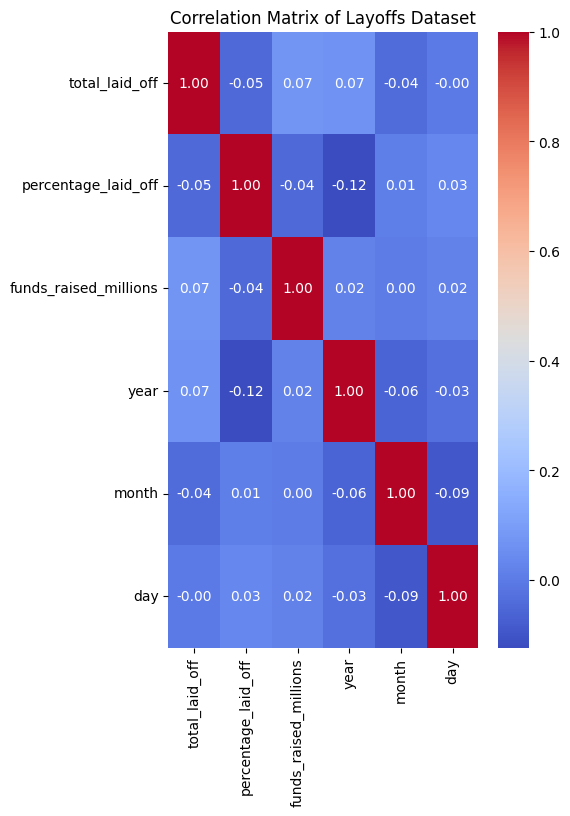

In [109]:
# Calculate the correlation matrix, selecting only numeric columns
correlation_matrix = Layoffs.select_dtypes(include=np.number).corr()

# Printing the correlation matrix
print(correlation_matrix)
#Visualizing
plt.figure(figsize=(5, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Layoffs Dataset')
plt.show()

<ipython-input-110-10236a72bb9d>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




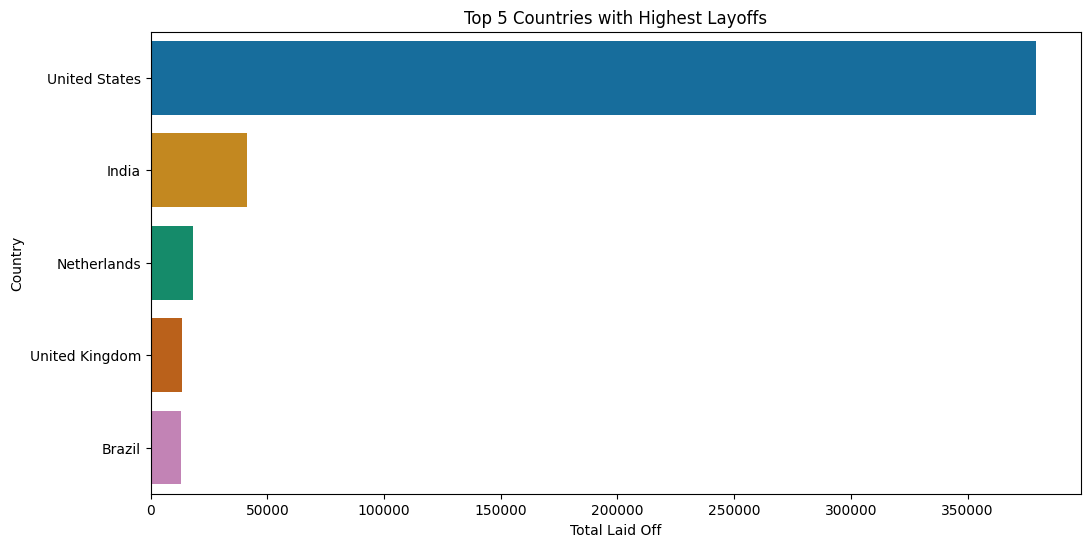

In [110]:
#Visualizing top5 countries with highest layoffs
plt.figure(figsize=(12, 6))
sns.barplot(data=top_5_countries, y='country', x='total_laid_off', palette="colorblind")
plt.title('Top 5 Countries with Highest Layoffs')
plt.xlabel('Total Laid Off')
plt.ylabel('Country')
plt.show()

In [111]:
#confirmming again the columns presented
Layoffs.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised_millions,formatted_date,year,month,day
0,Atlassian,Sydney,Other,500.0,0.050000,2023-03-06,Post-IPO,Australia,210.0,2023-03-06,2023,3,6
1,SiriusXM,New York City,Media,475.0,0.080000,2023-03-06,Post-IPO,United States,525.0,2023-03-06,2023,3,6
2,Alerzo,Ibadan,Retail,400.0,0.257917,2023-03-06,Series B,Nigeria,16.0,2023-03-06,2023,3,6
3,UpGrad,Mumbai,Education,120.0,0.257917,2023-03-06,Unknown,India,631.0,2023-03-06,2023,3,6
4,Loft,Sao Paulo,Real Estate,340.0,0.150000,2023-03-03,Unknown,Brazil,788.0,2023-03-03,2023,3,3


In [112]:
Industries_layoff_range=Layoffs.industry.value_counts()
Industries_layoff_range

,count
industry,
Finance,288
Retail,195
Healthcare,183
Transportation,148
Food,141
Marketing,139
Other,129
Consumer,118
Real Estate,117


In [113]:
#changing the created varilable limit to 8
Industries_layoff_range[:8]

,count
industry,
Finance,288
Retail,195
Healthcare,183
Transportation,148
Food,141
Marketing,139
Other,129
Consumer,118


<Axes: ylabel='count'>

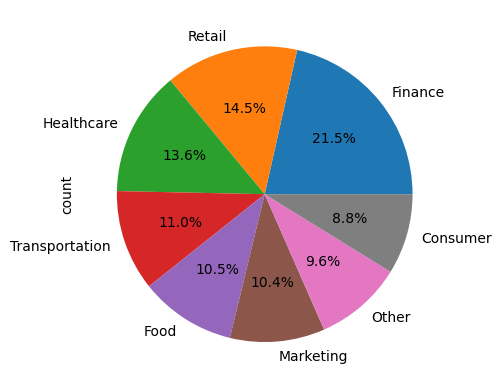

In [114]:
#plotting a pie chart
Industries_layoff_range[:8].plot(kind='pie', autopct='%1.1f%%')

<ipython-input-115-7713b59a491d>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




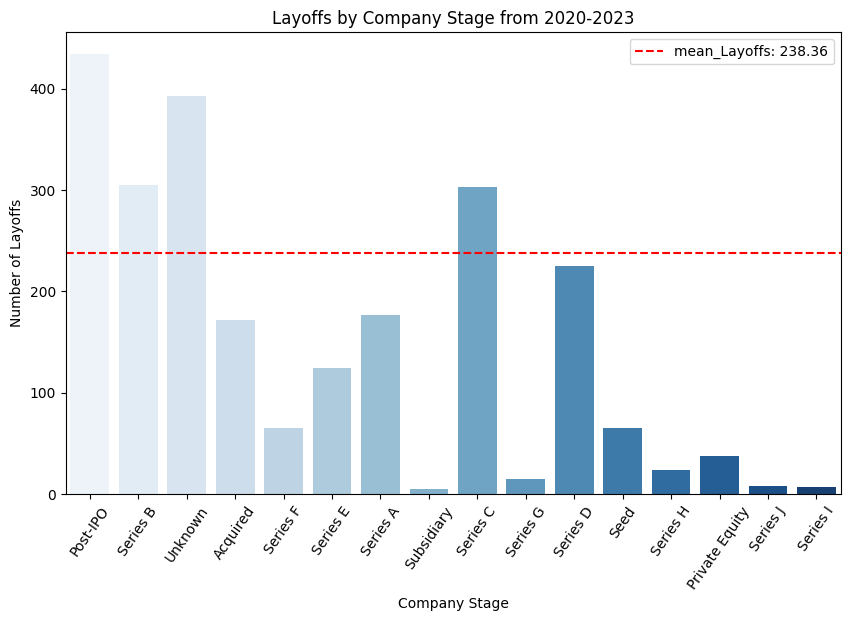

In [115]:
plt.figure(figsize=(10, 6))

# Using countplot for categorical data (if 'stage' is categorical)
sns.countplot(x='stage', data=Layoffs, palette='Blues')

# Adding title and labels
plt.title('Layoffs by Company Stage from 2020-2023')
plt.xlabel('Company Stage')  # Fixed typo here
plt.ylabel('Number of Layoffs')

# Calculate the mean number of layoffs across all stages (for vertical line)
mean_layoffs = Layoffs['total_laid_off'].mean()
#Visualizing
plt.axhline(mean_layoffs, color='red', linestyle='--', label=f'mean_Layoffs: {mean_layoffs:.2f}')
plt.legend()
plt.xticks(rotation=55)
plt.show()

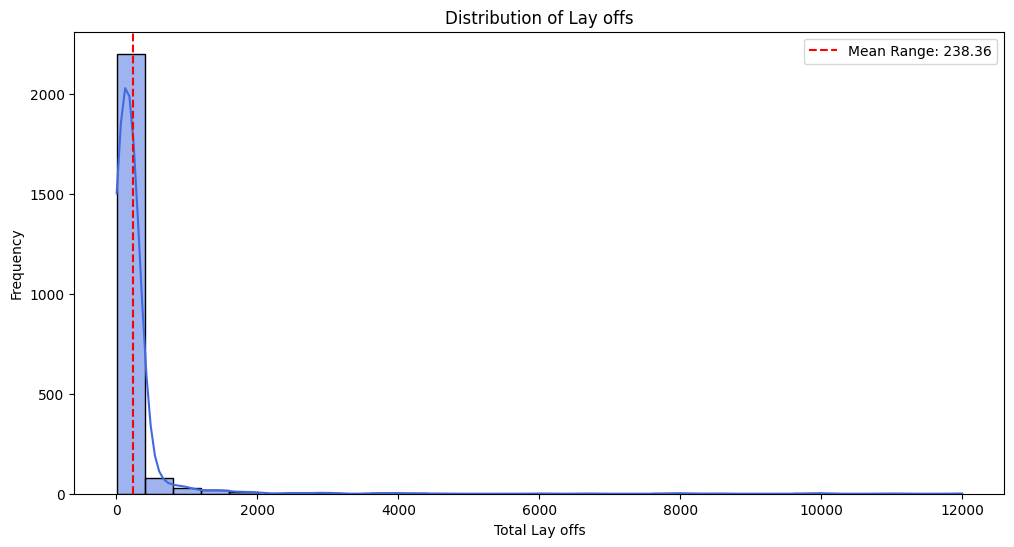

In [116]:
#visualizing distribution of layoffs
plt.figure(figsize=(12, 6))
sns.histplot(Layoffs['total_laid_off'], bins=30, kde=True, color='royalblue')
plt.title('Distribution of Lay offs')
plt.xlabel('Total Lay offs')
plt.ylabel('Frequency')
plt.axvline(Layoffs['total_laid_off'].mean(), color='red', linestyle='--', label=f'Mean Range: {Layoffs["total_laid_off"].mean():.2f}')
plt.legend()

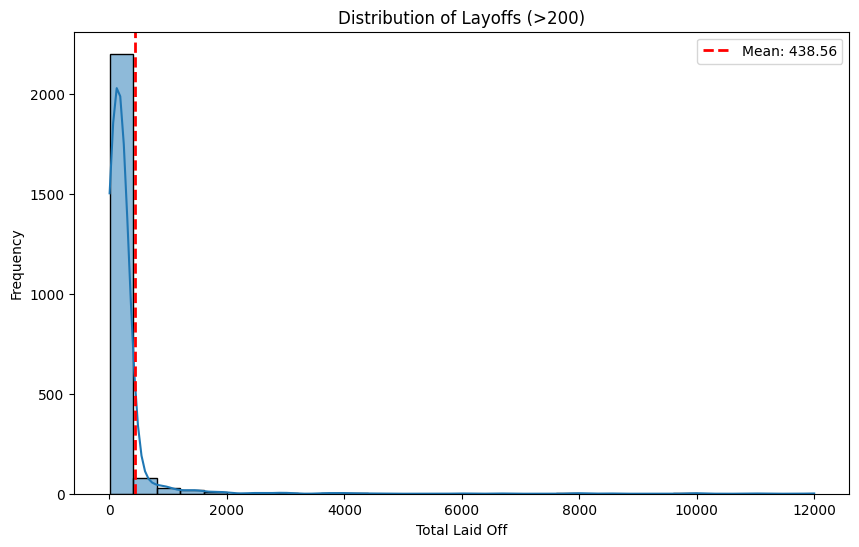

In [117]:
Filtered_total_laid_off = Layoffs[Layoffs['total_laid_off'] > 200]

# Plotting the distribution
plt.figure(figsize=(10, 6))

# Use kde=True to add a kernel density estimate
sns.histplot(Layoffs['total_laid_off'], kde=True, bins=30)

# Adding a vertical line for the mean of 'total_laid_off'
# Calculate the mean from the 'Filtered_total_laid_off' DataFrame, not 'Layoffs'
Filtered_total_laid_off_mean = Filtered_total_laid_off['total_laid_off'].mean()
plt.axvline(Filtered_total_laid_off_mean, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {Filtered_total_laid_off_mean:.2f}")

# Adding titles and labels
plt.title('Distribution of Layoffs (>200)')
plt.xlabel('Total Laid Off')
plt.ylabel('Frequency')

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [118]:
print(Layoffs.head())  # Preview the dataset
print(Layoffs.dtypes)  # Check data types again

     company       location     industry  total_laid_off  percentage_laid_off  \
0  Atlassian         Sydney        Other           500.0             0.050000   
1   SiriusXM  New York City        Media           475.0             0.080000   
2     Alerzo         Ibadan       Retail           400.0             0.257917   
3     UpGrad         Mumbai    Education           120.0             0.257917   
4       Loft      Sao Paulo  Real Estate           340.0             0.150000   

        date     stage        country  funds_raised_millions formatted_date  \
0 2023-03-06  Post-IPO      Australia                  210.0     2023-03-06   
1 2023-03-06  Post-IPO  United States                  525.0     2023-03-06   
2 2023-03-06  Series B        Nigeria                   16.0     2023-03-06   
3 2023-03-06   Unknown          India                  631.0     2023-03-06   
4 2023-03-03   Unknown         Brazil                  788.0     2023-03-03   

   year  month  day  
0  2023      3  

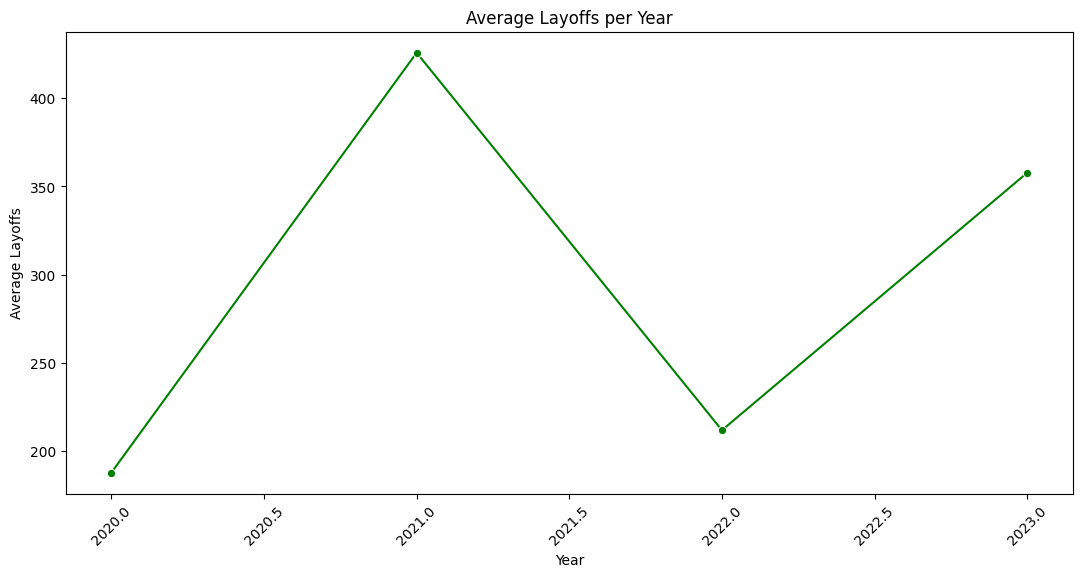

In [119]:
# Calculate the average layoffs per year
average_layoffs_by_year = Layoffs.groupby('year')['total_laid_off'].mean().reset_index()

# Creating the line plot
plt.figure(figsize=(13, 6))
# Visualizing
sns.lineplot(x='year', y='total_laid_off', data=average_layoffs_by_year, marker='o', color='green')
plt.title('Average Layoffs per Year')
plt.xlabel('Year')
plt.ylabel('Average Layoffs')
plt.xticks(rotation=45)
plt.show()

In [120]:
import plotly.express as px

#Interactive scatter plot of total layoffs by year and company
fig = px.scatter(Layoffs, x="year", y="total_laid_off", color="company", hover_data=['country', 'industry'],
                 title="Total Layoffs by Year and Company",
                 labels={"total_laid_off": "Total Laid Off", "year": "Year", "company": "Company"})
fig.show()


#Interactive bar chart of total layoffs by country
fig = px.bar(Layoffs.groupby('country')['total_laid_off'].sum().reset_index(),
             x="country", y="total_laid_off",
             title="Total Layoffs by Country",
             labels={"total_laid_off": "Total Laid Off", "country": "Country"})
fig.show()


#Interactive line plot of average layoffs per year
average_layoffs_by_year = Layoffs.groupby('year')['total_laid_off'].mean().reset_index()
fig = px.line(average_layoffs_by_year, x="year", y="total_laid_off",
              title="Average Layoffs per Year",
              labels={"total_laid_off": "Average Layoffs", "year": "Year"})
fig.show()

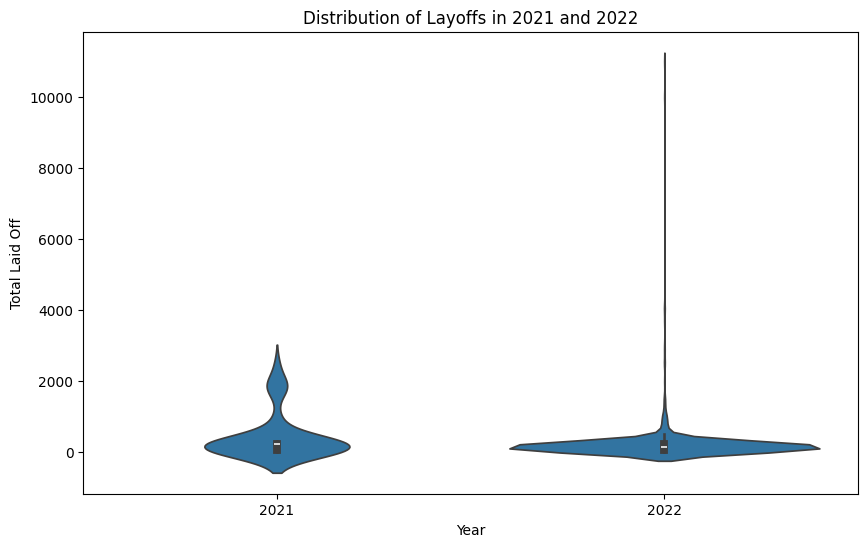

In [121]:
# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='year', y='total_laid_off', data=Layoffs[(Layoffs['year'] == 2021) | (Layoffs['year'] == 2022)])
plt.title('Distribution of Layoffs in 2021 and 2022')
plt.xlabel('Year')
plt.ylabel('Total Laid Off')
plt.show()

# Tech layoffs in 2022

In [122]:
# Importing data from google drive
Tech_layoffs = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tech_Layoffs_of_2022.csv")
Tech_layoffs.head(4)

,Unnamed: 0,Company,Founded,Layoff,Month,Year
0,0,Microsoft,1975,1000,October,2022
1,1,Twitter,2006,3700,November,2022
2,2,Meta,2004,11000,November,2022
3,3,Netflix,1997,300,June,2022


In [123]:
# Check for missing values
print("Missing values before cleaning:", Tech_layoffs.isnull().sum())
#as there are no missing values proceeding for next steps

Missing values before cleaning: Unnamed: 0    0
Company       0
Founded       0
Layoff        0
Month         0
Year          0
dtype: int64


In [124]:
# Display data types of each column
print(Tech_layoffs.dtypes)

Unnamed: 0     int64
Company       object
Founded        int64
Layoff         int64
Month         object
Year           int64
dtype: object


In [125]:
# Exclude non-numeric columns from correlation analysis
numeric_data = Tech_layoffs.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

# Visualize correlation matrix with background gradient
correlation_matrix.style.background_gradient(cmap='viridis')

,Unnamed: 0,Founded,Layoff,Year
Unnamed: 0,1.000000,-0.201161,-0.184056,-0.227172
Founded,-0.201161,1.000000,0.017460,-0.058810
Layoff,-0.184056,0.017460,1.000000,0.027785
Year,-0.227172,-0.058810,0.027785,1.000000


      Company  Layoff
0      Amazon  100000
1        Meta   11000
2    Cineplex    5000
3  Better.Com    4150
4     Twitter    3700


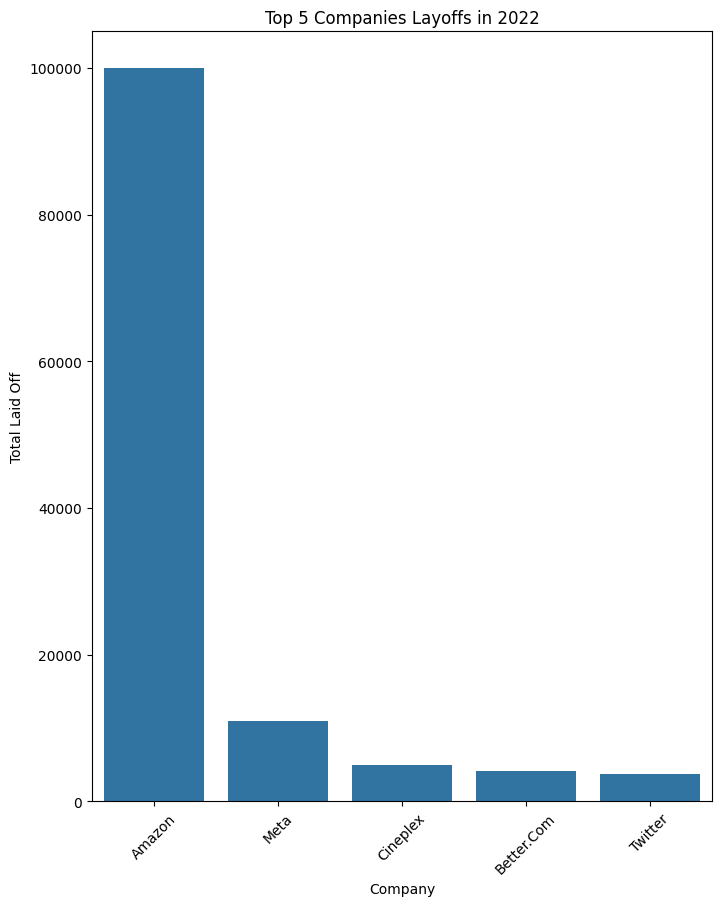

In [126]:
top_5_companies = Tech_layoffs.groupby('Company')['Layoff'].sum().nlargest(5).reset_index()

print(top_5_companies.head())

#Visualizing the Layoffs by companies in 2022
plt.figure(figsize=(8, 10))
sns.barplot(data=top_5_companies, x='Company', y='Layoff')
plt.title('Top 5 Companies Layoffs in 2022')
plt.xlabel('Company')
plt.ylabel('Total Laid Off')
plt.xticks(rotation=45)
plt.show()

<ipython-input-127-c4537acb342f>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




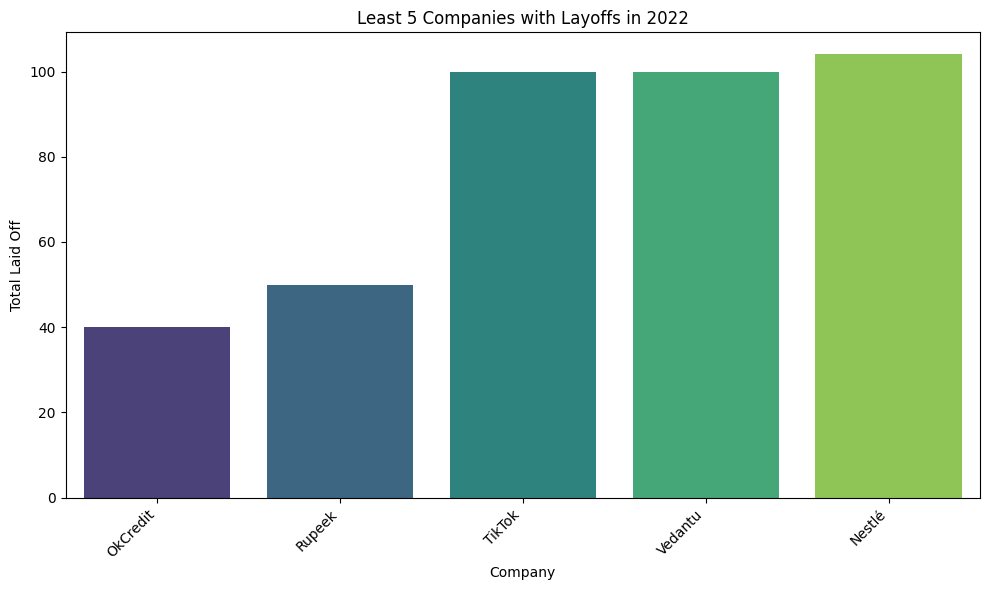

In [127]:
#least laidoff tech companies
# Group by company and sum layoffs
company_layoffs = Tech_layoffs.groupby('Company')['Layoff'].sum().reset_index()

# Get the 5 companies with the least layoffs
bottom_5_companies = company_layoffs.nsmallest(5, 'Layoff')


plt.figure(figsize=(10, 6))
sns.barplot(data=bottom_5_companies, x='Company', y='Layoff', palette='viridis')
plt.title('Least 5 Companies with Layoffs in 2022')
plt.xlabel('Company')
plt.ylabel('Total Laid Off')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<ipython-input-128-f6ad95a1e3af>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




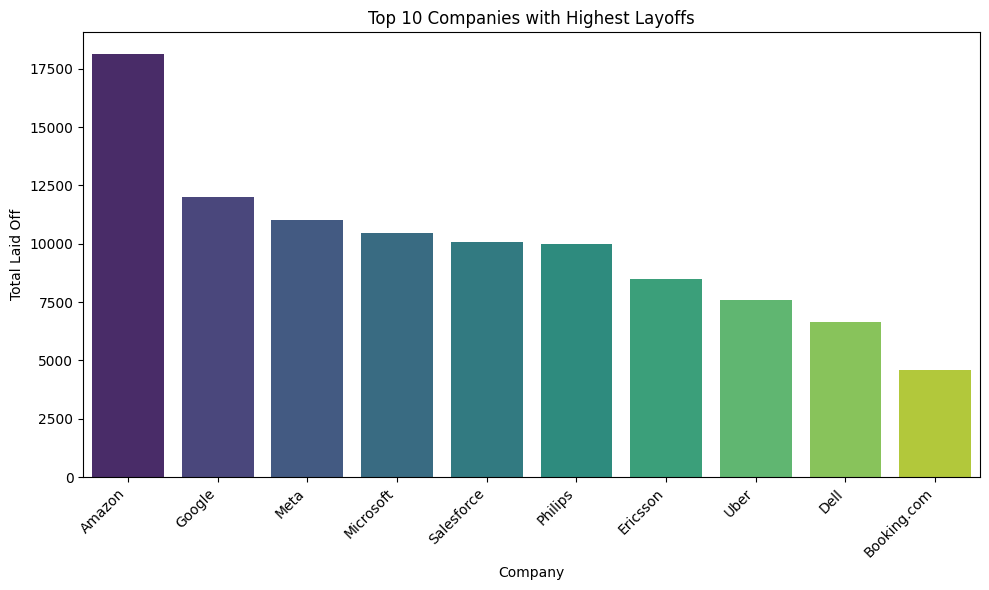

In [128]:
# Group by company and find the top 10 companies with the highest layoffs
top_companies = Layoffs.groupby('company')['total_laid_off'].sum().nlargest(10).reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data=top_companies, x='company', y='total_laid_off', palette='viridis')

# Add labels and title
plt.xlabel('Company')
plt.ylabel('Total Laid Off')
plt.title('Top 10 Companies with Highest Layoffs')
plt.xticks(rotation=45, ha='right')
# Display the plot
plt.tight_layout()
plt.show()


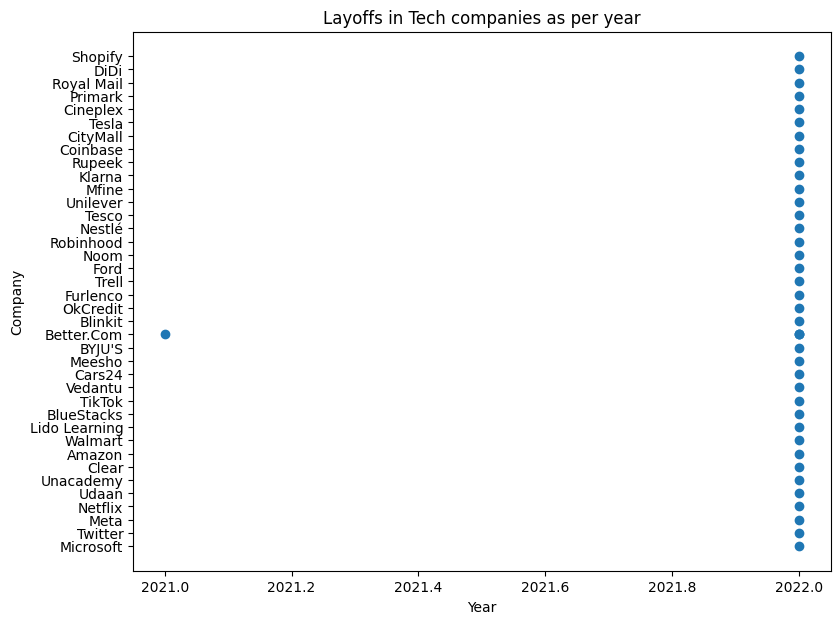

In [129]:
# Creating the scatter plot
plt.figure(figsize=(9, 7))
plt.scatter(Tech_layoffs['Year'], Tech_layoffs['Company'])
plt.xlabel('Year')
plt.ylabel('Company')
plt.title('Layoffs in Tech companies as per year')
plt.grid(False)
plt.show()

In [130]:
# top 5 laidoff companies and their founded year
top_companies =Tech_layoffs.groupby('Company')['Layoff'].sum().nlargest(5).reset_index()
top_companies = pd.merge(top_companies, Tech_layoffs[['Company', 'Founded']], on='Company', how='left').drop_duplicates(subset=['Company'])
print(top_companies[['Company', 'Founded']])

      Company  Founded
0      Amazon     1994
1        Meta     2004
2    Cineplex     1999
3  Better.Com     2016
7     Twitter     2006


In [131]:
# the month with the most layoffs in 2022
month_layoffs = Tech_layoffs.groupby('Month')['Layoff'].sum()
month_with_most_layoffs = month_layoffs.idxmax()
print(f"The month with the most layoffs is: {month_with_most_layoffs}")

The month with the most layoffs is: July


In [132]:
#Interactive scatter plot of total layoffs by year and company for Tech
fig = px.scatter(Tech_layoffs, x="Year", y="Layoff", color="Company",
                 title="Total Layoffs by Founded Year and Company (Tech Layoffs 2022)",
                 labels={"Layoff": "Total Laid Off", "Year": "Year ", "Company": "Company"})
fig.show()

The most reason for the layoffs in these different industries is due to the AI evolution, AI made the tasks easier and reduced the manual effors which automatically reduced the man force in work areas, especially in IT firms AI adoptation is reducing errors, efforts and main thing Cost.

so, as we have choosen the layoff topic, and created a detailed analysis. we would like to explore the AI related data sets, covering the details like


*   companies adopting AI
*   Market values of AI
*   Organizations planning to implement AI
*   revenue from AI     and many more

EDA for AI is below





# EDA for AI

## Analysis for Top 50 AI companies as per forbes 2024

In [133]:
top50_AI = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI50 2024.csv")
top50_AI.head(5)

,NAME,WHAT IT DOES,FUNDING,YEAR FOUNDED,HEADQUARTERS
0,Abridge,Medical conversation documentation,$213 M,2018,"Pittsburgh, Pennsylvania, United States"
1,Adept,AI model developer,$415 M,2022,"San Francisco, California, United States"
2,Anduril Industries,Defense software and hardware,$2.8 B,2017,"Costa Mesa, California, United States"
3,Anthropic,AI model developer,$7.7 B,2020,"San Francisco, California, United States"
4,Anyscale,AI app deployment software,$259 M,2019,"San Francisco, California, United States"


In [134]:
# Check for missing values
print("Missing values before cleaning:", top50_AI.isnull().sum())

Missing values before cleaning: NAME            0
WHAT IT DOES    0
FUNDING         0
YEAR FOUNDED    0
HEADQUARTERS    0
dtype: int64


As there are no missing values proceeding for visualization

In [135]:
# AI companies as per founded year
company_counts_by_year = top50_AI.groupby('YEAR FOUNDED')['NAME'].count()
company_counts_by_year

,NAME
YEAR FOUNDED,
2013,2
2015,1
2016,5
2017,5
2018,3
2019,11
2020,4
2021,7
2022,8


In [136]:
import pandas as pd

# Function to clean the numeric column by removing letters and special characters
def clean_numeric_column(df, FUNDING):
    # Converting the column to string and remove non-numeric characters
    df[FUNDING] = df[FUNDING].astype(str).str.replace(r'[^0-9]', '', regex=True)
    # Convert the cleaned column back to numeric
    df[FUNDING] = pd.to_numeric(df[FUNDING], errors='coerce')
    return df

top50_AI = clean_numeric_column(top50_AI, 'FUNDING ')

# Display the first few rows to verify
print(top50_AI[['NAME', 'FUNDING ']].head())

                 NAME  FUNDING 
0             Abridge       213
1               Adept       415
2  Anduril Industries        28
3           Anthropic        77
4            Anyscale       259


In [137]:
top50_AI.head()

,NAME,WHAT IT DOES,FUNDING,YEAR FOUNDED,HEADQUARTERS
0,Abridge,Medical conversation documentation,213,2018,"Pittsburgh, Pennsylvania, United States"
1,Adept,AI model developer,415,2022,"San Francisco, California, United States"
2,Anduril Industries,Defense software and hardware,28,2017,"Costa Mesa, California, United States"
3,Anthropic,AI model developer,77,2020,"San Francisco, California, United States"
4,Anyscale,AI app deployment software,259,2019,"San Francisco, California, United States"


<ipython-input-138-b0ddb4300139>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




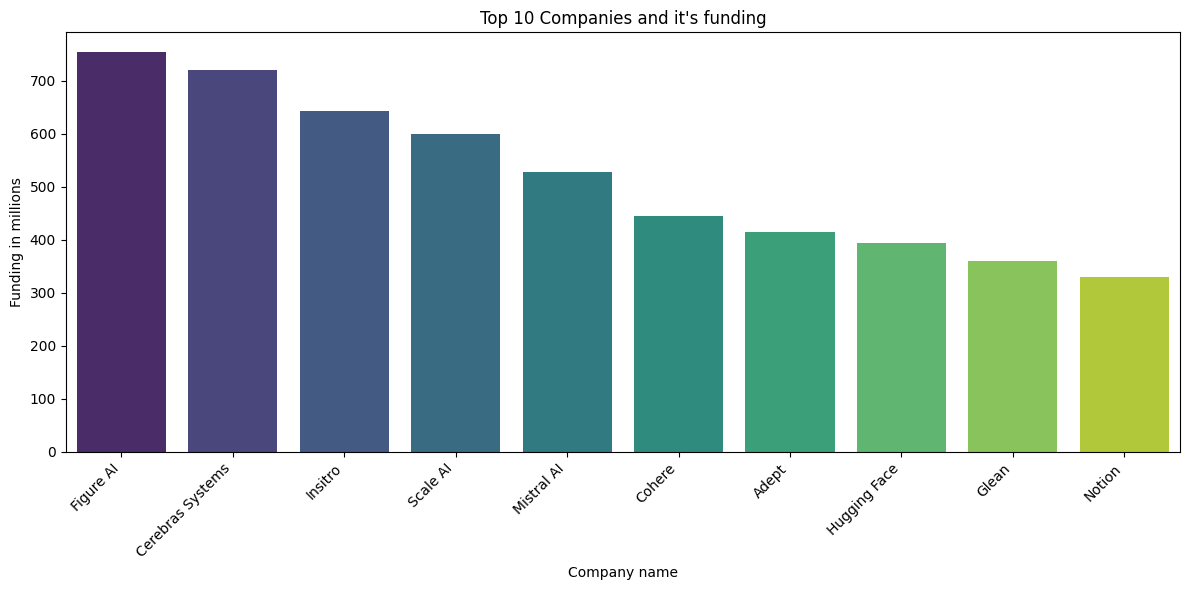

In [138]:
# Group by company and sum total_laid_off, then get the top 10
top_10_funding_companies = top50_AI.groupby('NAME')['FUNDING '].sum().nlargest(10).reset_index()

# Visualizing the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='NAME', y='FUNDING ', data=top_10_funding_companies, palette='viridis')
plt.xlabel('Company name')
plt.ylabel('Funding in millions')
plt.title("Top 10 Companies and it's funding")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<ipython-input-139-19a5e9ea10ec>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




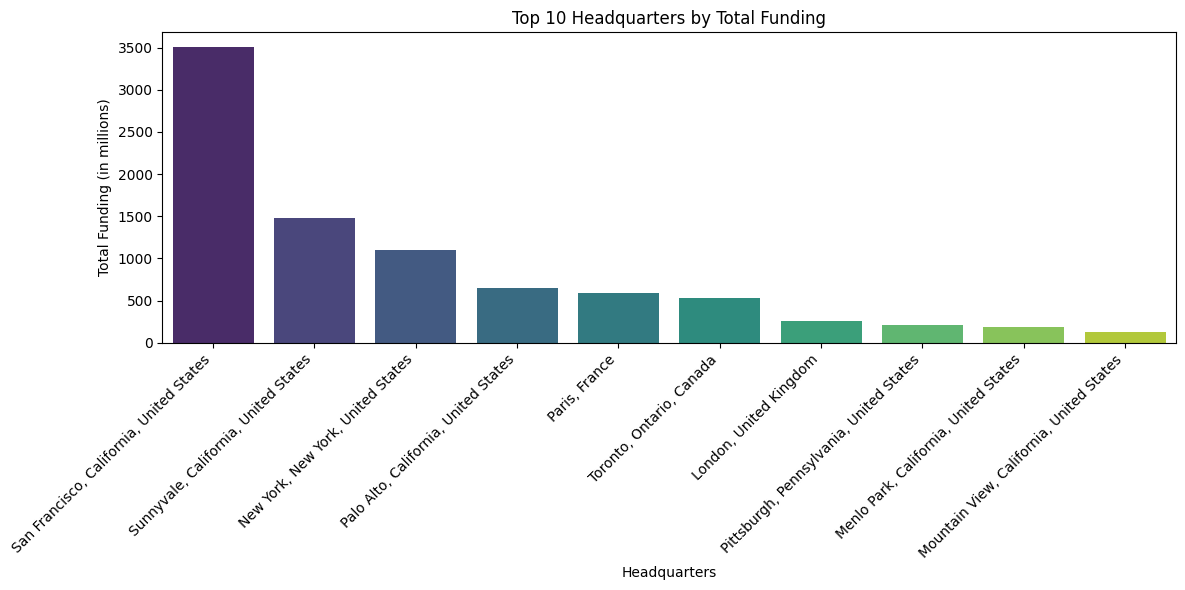

In [139]:
# Group by headquarters and sum funding
headquarters_funding = top50_AI.groupby('HEADQUARTERS')['FUNDING '].sum().nlargest(10).reset_index()

# visualizing the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='HEADQUARTERS', y='FUNDING ', data=headquarters_funding, palette='viridis')
plt.xlabel('Headquarters')
plt.ylabel('Total Funding (in millions)')
plt.title('Top 10 Headquarters by Total Funding')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

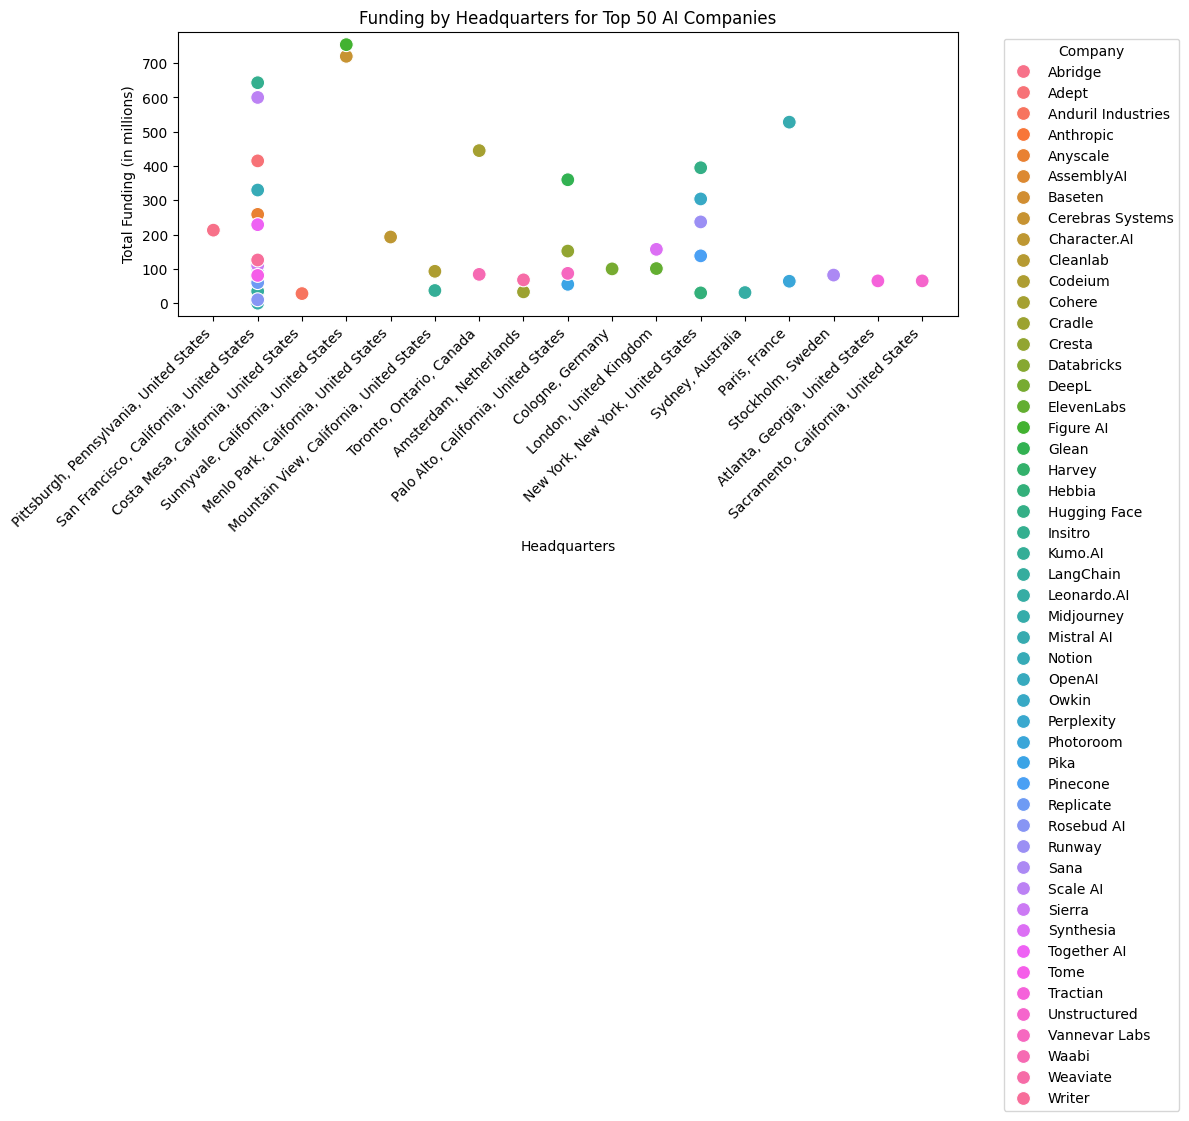

In [140]:
#scatter plot for companies it's head quarter and funding

import matplotlib.pyplot as plt
import seaborn as sns

# Creating the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=top50_AI, x='HEADQUARTERS', y='FUNDING ', hue='NAME', s=100)
plt.title('Funding by Headquarters for Top 50 AI Companies')
plt.xlabel('Headquarters')
plt.ylabel('Total Funding (in millions)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [141]:
import plotly.express as px

# Interactive scatter plot of funding by headquarters
fig = px.scatter(top50_AI, x="HEADQUARTERS", y="FUNDING ", color="NAME",
                 title="Funding by Headquarters for Top 50 AI Companies",
                 labels={"FUNDING ": "Total Funding (in millions)", "HEADQUARTERS": "Headquarters", "NAME": "Company"},
                 hover_data=['YEAR FOUNDED'])
fig.update_layout(xaxis_title="Headquarters", xaxis={'categoryorder':'total descending'})
fig.show()

## EDA for AI Usage

In [142]:
# Importing data from google drive
AI_USE = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/The Rise Of Artificial Intellegence2.csv")
AI_USE.head()

,Year,AI Software Revenue(in Billions),Global AI Market Value(in Billions),AI Adoption (%),Organizations Using AI,Organizations Planning to Implement AI,Global Expectation for AI Adoption (%),Estimated Jobs Eliminated by AI (millions),Estimated New Jobs Created by AI (millions),Net Job Loss in the US,...,Estimated Revenue Increase from AI (trillions USD),Marketers Believing AI Improves Email Revenue,Expected Increase in Employee Productivity Due to AI (%),Americans Using Voice Assistants (%),Digital Voice Assistants (billions of devices),Medical Professionals Using AI for Diagnosis,AI Contribution to Healthcare(in Billions),Jobs at High Risk of Automation - Transportation & Storage (%),Jobs at High Risk of Automation - Wholesale & Retail Trade,Jobs at High Risk of Automation - Manufacturing
0,2018,10.10,29.5,10%,35%,40%,40%,10%,5%,7%,...,1.2,41.29%,5%,20%,1.5,38%,461,35%,44%,46.40%
1,2019,14.69,35.0,20%,37%,42%,47%,15%,8%,6.50%,...,1.8,42%,7%,25%,2.0,39%,465,38%,45%,47%
2,2020,22.59,45.0,30%,40%,45%,54%,20%,12%,6%,...,2.4,43%,9%,30%,2.6,41%,470,40%,46%,47.50%
3,2021,34.87,65.0,35%,42%,47%,61%,25%,16%,5.50%,...,3.0,44%,11%,35%,3.2,43%,475,43%,47%,48%
4,2022,51.27,140.0,35%,45%,50%,68%,30%,20%,5%,...,3.6,45%,13%,40%,3.8,45%,480,45%,48%,48.50%


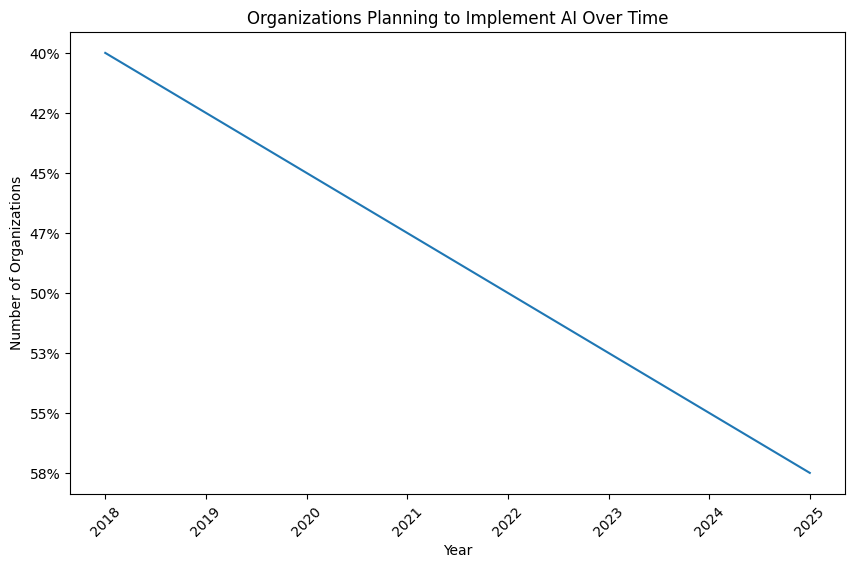

In [143]:
#visualizing line plot for organizations implemnting AI over years
plt.figure(figsize=(10, 6))
sns.lineplot(data=AI_USE, x='Year', y='Organizations Planning to Implement AI')
plt.title('Organizations Planning to Implement AI Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Organizations')
plt.xticks(rotation=45)
plt.show()

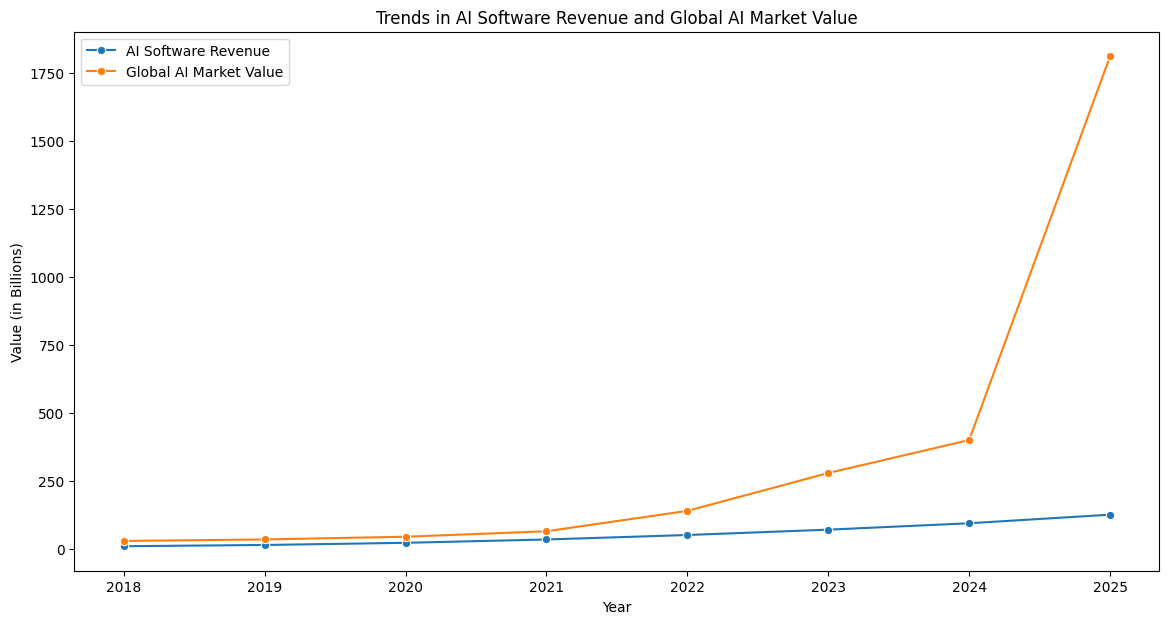

In [144]:
#Line Plot for AI Software Revenue and Global AI Market Value over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Year', y='AI Software Revenue(in Billions)', data=AI_USE, label='AI Software Revenue', marker='o')
sns.lineplot(x='Year', y='Global AI Market Value(in Billions)', data=AI_USE, label='Global AI Market Value', marker='o')
plt.title('Trends in AI Software Revenue and Global AI Market Value')
plt.xlabel('Year')
plt.ylabel('Value (in Billions)')
plt.legend()
plt.show()

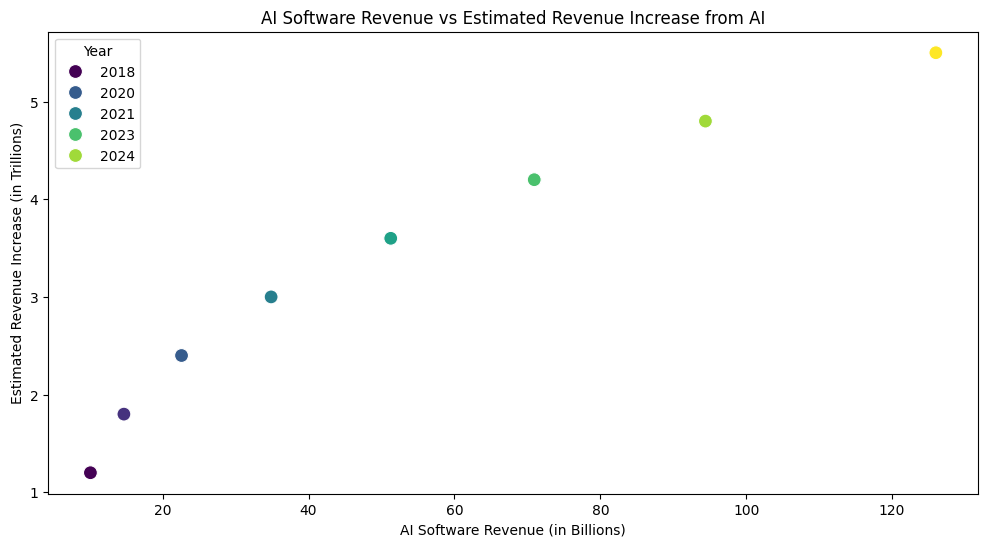

In [145]:
#Scatter Plot for Estimated Revenue Increase from AI vs. AI Software Revenue
plt.figure(figsize=(12, 6))
sns.scatterplot(x='AI Software Revenue(in Billions)', y='Estimated Revenue Increase from AI (trillions USD)', data=AI_USE, hue='Year', palette='viridis', s=100)
plt.title('AI Software Revenue vs Estimated Revenue Increase from AI')
plt.xlabel('AI Software Revenue (in Billions)')
plt.ylabel('Estimated Revenue Increase (in Trillions)')
plt.legend(title='Year')
plt.show()

# Summary

AS a summary, Exploratory data analysis showed that AI-driven layoffs are heavy across industries and time, with an extra jump at the close of 2021, the highest was in July 2022. The market is seeing exponential growth in AI: AI software revenues have been increasing from 2018 to 2024, underpinning the rising dependence on AI technologies as a lever of innovation and efficiency. While AI has displaced millions of jobs, it has also created opportunities in specialized fields like data science and AI engineering, although these often require advanced skills, leading to a growing skills gap. The United States, as a leader in AI advancements and funding, has faced the highest number of layoffs, reflecting a direct correlation between high AI adoption and workforce reductions. Meanwhile, the percentage of organizations that would be implementing AI is expected to rise from 40% to 58% by 2025, showing a wider trend toward automation across industries. The top AI companies, mostly founded after 2018, leveraged more than $23 billion in funding to develop transformative technologies, reshape industries, and drive growth while exacerbating job losses in routine and repetitive roles. This heightens the urgent need for reskilling programs and adaptive strategies in balancing innovation with workforce sustainability.

# Conclusion

we would like to conclude with The analysis of layoffs and the impact of AI make for a dual-edged sword of technological development. While AI has surely proven to be a disruptive element, driving innovation, efficiency, and economic growth in various sectors, it has also contributed hugely to workforce displacement, particularly in industries that are more vulnerable to automation. The data shows uneven layoff patterns across time and regions; countries like the United States are bearing the brunt of this due to its high AI adoption rates. While AI has opened opportunities for new and specialized roles, the growing skills gap challenges workforce sustainability. The rise in the adoption of AI is predicted to continue; hence, this becomes of paramount importance: reskilling initiatives by organizations, governments, and policymakers, investment in education about emerging technologies, and policy decisions toward equitable transition in the era of the AI economy. Society can ensure a balance of benefits from AI only with proactive workforce strategies while minimizing its adverse impacts on jobs.